# How to perform optimization and simulation in the same calculation
**Perform calculations using optimization results in a single graph**

In Boulder Opal the highly-flexible optimization engine can easily be combined with simulation nodes to perform both optimization and simulation, all in a single graph. 
This means that one can first optimize the parameters of a Hamiltonian for some task, and then simulate the evolution with the optimized parameters. 
Note that adding simulation nodes to the optimization graph doesn't create any overhead to the calculation (as long as the cost node does not depend on the additional nodes), as the added nodes are only calculated after the optimization has been completed.
If instead you want to reuse graphs or parts of a graph in different calculations, see the user guide [How to reuse graph definitions in different calculations](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-reuse-graph-definitions-in-different-calculations).

Below we show an example of how to optimize a pulse, and then simulate evolution under the optimized pulse, in a single graph.

## Summary workflow
### 1. Define the optimization computational graph
Start by setting up a [graph object](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-represent-quantum-systems-using-graphs) to carry out your optimization, be it to perform a [control optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-controls-in-arbitrary-quantum-systems-using-graphs) or [system identification](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-perform-parameter-estimation-with-a-small-amount-of-data) task.

### 2. Add nodes using the optimized results
Add nodes to the same graph that use the optimized results, such as calculating [time-evolution operators](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/Graph/time_evolution_operators_pwc) with the optimized controls, or the [Hessian](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/Graph/hessian) to estimate the confidence region of the estimated parameters.

### 3. Run graph-based optimization
With the graph object created, an optimization can be run using the `boulderopal.run_optimization` function. In addition to returning the results of the optimization, this function will also evaluate the nodes in `output_node_names` using the optimized variables.

## Example: Pulse optimization and simulation of a qutrit in a single graph
In this example we apply a pulse to a qubit subject to leakage to an additional level. The resulting qutrit is treated as an oscillator (truncated to three levels) with an anharmonicity of $\chi$, described by the Hamiltonian:

$$
H(t) = \frac{\chi}{2} (a^\dagger)^2 a^2 + \frac{\Omega(t)}{2} a + \frac{\Omega^*(t)}{2} a^\dagger,
$$

where $a = \left|0 \right\rangle \left\langle 1 \right| + \sqrt{2} \left|1 \right\rangle \left\langle 2 \right|$ is the lowering operator and $\Omega(t)$ is a time-dependent Rabi rate. The form of $\Omega(t)$ is 
$$\Omega(t) = A \tanh\left( \frac{t - t_0}{T} \right)$$
where the amplitude $A$, and center time $t_0$, are optimizable parameters, and $T$ is the duration of the pulse.

We choose as our target an X gate between the states $\left| 0 \right\rangle$ and $\left| 1 \right\rangle$. Notice that this target is not unitary in the total Hilbert space, but is still a valid target because it is a partial isometry—in other words, it is unitary in the subspace whose basis is $\{ \left| 0 \right\rangle, \left| 1 \right\rangle \}$.

After optimizing $A$ and $t_0$ to produce an X gate, we evolve the qutrit state $|0\rangle$ under the optimized Hamiltonian, expecting it to evolve to $|1\rangle$. We optimize and simulate in a single graph.

In [1]:
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

In [2]:
n_levels = 3  # The number of levels in the system.

# Define the Pulse parameters.
segment_count = 50
duration = 10e-6  # s

graph = bo.Graph()

# Define the anharmonic term.
chi = 2 * np.pi * 3 * 1e8  # rad/s
n = graph.number_operator(n_levels)
anharmonic_drift = 0.5 * chi * (n @ n - n)

# Define Rabi drive term.
omega_end_value = graph.optimizable_scalar(lower_bound=0.0, upper_bound=3e7)
omega_center_time = graph.optimizable_scalar(lower_bound=0.0, upper_bound=duration)
omega_pulse = graph.signals.tanh_ramp_pwc(
    duration=duration,
    segment_count=segment_count,
    end_value=omega_end_value,
    center_time=omega_center_time,
    ramp_duration=duration,
    name="$\\Omega$",
)

a = graph.annihilation_operator(n_levels)
rabi_drive = graph.hermitian_part(omega_pulse * a)

# Define Hamiltonian.
hamiltonian = anharmonic_drift + rabi_drive

# Define the target (X gate).
target = np.zeros((n_levels, n_levels))
target[0, 1] = 1
target[1, 0] = 1
target = graph.target(operator=target)

# Calculate the infidelity.
infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian, target=target, name="infidelity"
)

# All the nodes we add below do not influence the cost node (infidelity).

# Define the initial state.
initial_state = graph.fock_state(n_levels, 0)[:, None]

# Calculate the time evolution operators.
sample_times = np.linspace(0, duration, 100)
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times, name="time_evolution_operators"
)

evolved_states = unitaries @ initial_state
evolved_states.name = "evolved_states"

# Run optimization and simulation.
result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=[
        "infidelity",
        "$\\Omega$",
        "time_evolution_operators",
        "evolved_states",
    ],
    optimization_count=4,
)

# Extract and print final infidelity.
print(f"Final infidelity: {result['output'].pop('infidelity')['value']:.1e}")

# Extract and print final time evolution operator.
print("Total time evolution operator:")
print(np.round(result["output"].pop("time_evolution_operators")["value"][-1], 3))

# Extract and plot state populations.
state_vectors = result["output"].pop("evolved_states")["value"]
final_populations = np.abs(state_vectors) ** 2

Your task (action_id="1829423") has started.
Your task (action_id="1829423") has completed.
Final infidelity: 1.9e-06
Total time evolution operator:
[[-0.   +0.j    -0.011+1.j    -0.   +0.001j]
 [-0.01 +1.j     0.   -0.j     0.002-0.j   ]
 [ 0.   -0.002j -0.001+0.j     1.   -0.021j]]


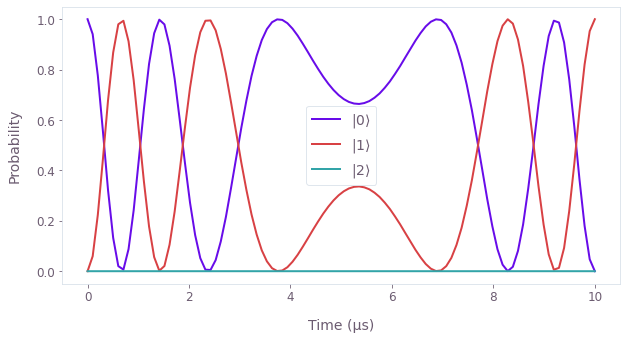

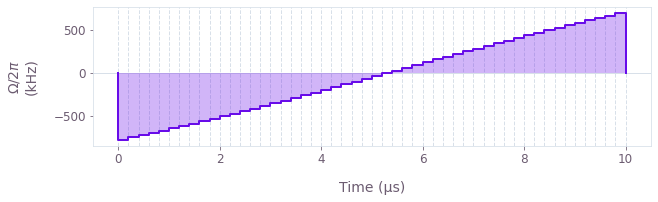

In [3]:
# Plot populations evolution.
qv.plot_population_dynamics(
    sample_times,
    {rf"$|{state}\rangle$": final_populations[:, state] for state in range(n_levels)},
)

# Plot optimized control.
qv.plot_controls(result["output"])